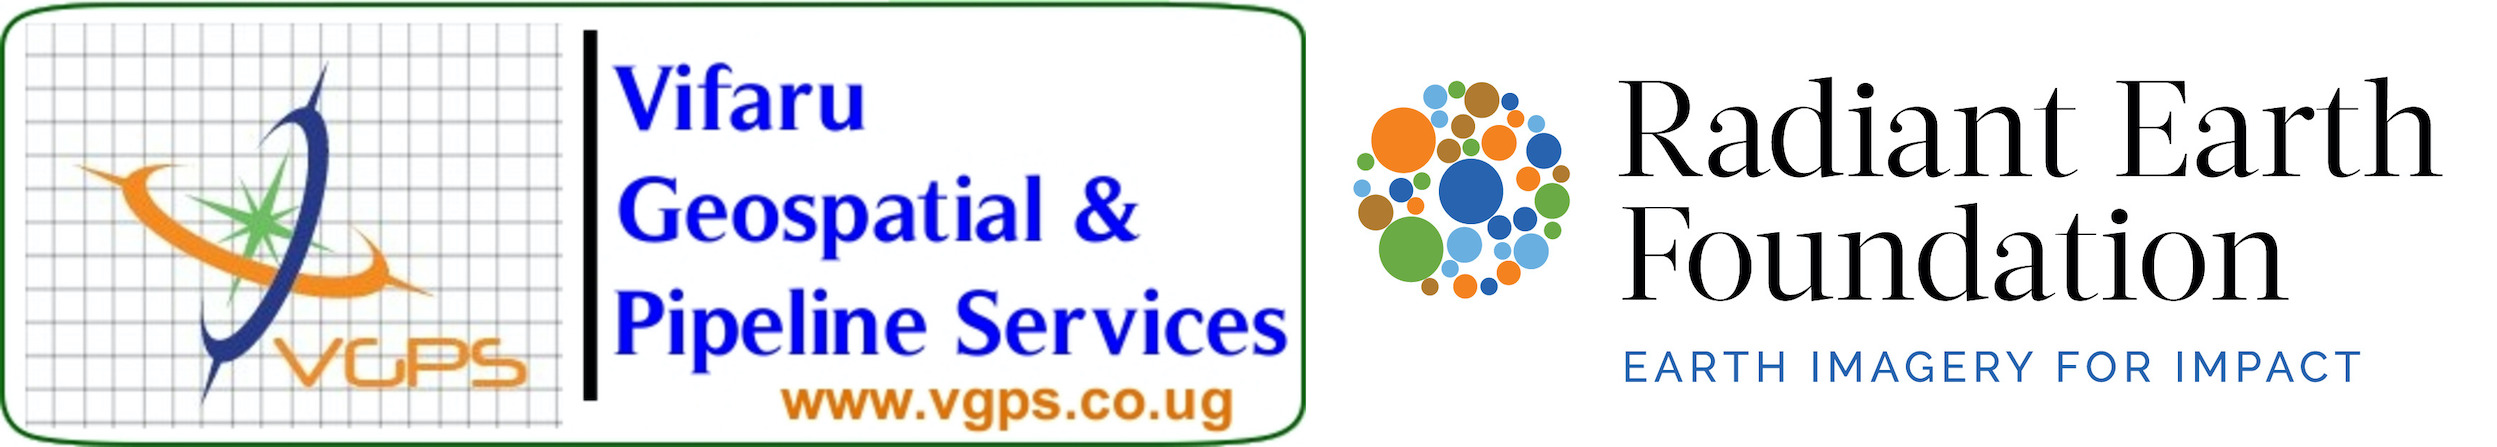

Machine Learning for Earth Observation (ML4EO) Training
=================================================

## Chapter 2.2 : Cleaning the Geospatial Datasets



Exercise 2 - Cleaning Input Data
---

In this exercise we will work with the same input data as the first exercise. We will convert the input data from the shapefile format to a more user-friendly GeoJSON format, reproject to the same projection as the Sentinel-2 Imagery will be in, fix invalid geometries, and rename similar field values so that they are the same.

In [1]:
import fiona
from shapely.geometry import shape, mapping
from shapely.ops import transform
import json
import pyproj
import geopandas as gpd

input_data = fiona.open("../data/south_africa_crops/south_africa_crops.shp")

Configuration
---

This cell defines the coordinate reference system we will reproject the geometries to (UTM Zone 34S), the name of the field which contains the label (CROPS), the names of the fields which will be kept and not dropped (CROPS, CAPDATE), and the mapping of similar values to the same value.

In [2]:
DESTINATION_CRS = 'EPSG:32734'

CLASS_PROPERTY = 'CROPS'
FEATURE_PROPERTIES = [ CLASS_PROPERTY, 'CAPDATE' ]

CLASS_MAPPING = {
    'Barley': [ 'Barley' ],
    'Leeks': [ 'Leeks' ],
    'Peppers': [ 'Peppers' ],
    'Oranges': [ 'Oranges', 'Orange', 'orange' ],
    'Tomatoes': [ 'Tomatoes' ],
    'Wheat': [ 'Wheat' ]
}

Copying Features, Dropping Properties, and Mapping Properties
---

In this cell we iterate through every record in the input data, map similar `CROPS` field values to the same value, drop properties which we are not interested in, and add each record to the `features` array which we will use when exporting our dataset to a GeoJSON file.

In [3]:
features = [ ]

for row in input_data:
    feature_properties = {}
    
    raw_class = row['properties'].get(CLASS_PROPERTY)
    cleaned_class = 'N/A'
    
    for new_class, raw_classes in CLASS_MAPPING.items():
        if raw_class in raw_classes:
            cleaned_class = new_class
            break
    
    row['properties'][CLASS_PROPERTY] = cleaned_class
    
    for key, value in row['properties'].items():
        if key in FEATURE_PROPERTIES:
            feature_properties[key] = value
        
    row['properties'] = feature_properties
    row['geometry'] = shape(row['geometry'])
    
    features.append(row)

Visualizing Automatic Geometry Fixing
---

This cell shows how the automatic fixing of invalid geometries does not always produce the result you would expect. In this case we would expect the fixed geometry to look more like a single rectangle rather than a rectangle and a triangle. Usually it is best to manually edit the geometries in software like [QGIS](https://www.qgis.org/en/site/) and match it with imagery so the edited geometries match the actual field geometry exactly. However, this process is very time intensive and is not feasible for very large datasets. In this exercise we will use the automatic method as it is "good enough".

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

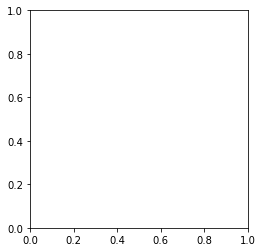

In [4]:
for feature in features:
    if not feature['geometry'].is_valid:
        gpd.GeoSeries(feature['geometry']).plot()
        feature['geometry'] = feature['geometry'].buffer(0)
        gpd.GeoSeries(feature['geometry']).plot()
        break

In [ ]:
for feature in features:
    if not feature['geometry'].is_valid:
        feature['geometry'] = feature['geometry'].buffer(0)

Transforming CRS
---

This cell will iterate through every field and reproject its geometry to the final UTM Zone 34S coordinate reference system.

In [ ]:
src_crs = pyproj.CRS(input_data.crs)
dst_crs = pyproj.CRS(DESTINATION_CRS)

project = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True).transform

for feature in features:
    feature['geometry'] = mapping(transform(project, feature['geometry']))

Saving GeoJSON
---

Finally, we save the dataset as a GeoJSON file.

In [ ]:
with open('../data/labels.geojson', 'w') as f:
    f.write(json.dumps({
        'type': 'FeatureCollection',
        'features': features,
        'crs': {
            'type': 'name',
            'properties': {
                'name': DESTINATION_CRS
            }
        }
    }, indent=4))

Next Lesson ([Hands-on 3: Match Imagery Datasets](Lesson2_3_matching_imagery.ipynb)) demonstrates how to match imagery datasets.